## Graphical Analysis of Perceptions of Immigration in Pre- and Post- Refugee Crisis Europe

- Katharina Klaunig
- Luna Schlör

The following graphs illustrate refugee influx in Europe during the 2015 refugee crisis as well as differences in attitudes towards immigrants and immigration in European countries between 2014 and 2016. The data stems from the [European Social Survey](https://www.europeansocialsurvey.org/about/) which is a cross national survey conducted every two years measuring attitudes, beliefs and behaviour patterns in Europe. We specifically use data from the years 2014 and 2016, right before and right after the 2015 refugee crisis. From the [OECD](http://www.oecd.org/els/mig/keystat.htm) we further drew data on refugee influx while population data is based on estimations of the [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL?end=2018&start=2008).

In [10]:
# importing packages 
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import seaborn as sns
from descartes import PolygonPatch
import country_converter as coco
import json

In [11]:
# importing the data
# European Social Survey
fourteen = pd.read_csv('ESS_2014.csv')
fourteen
sixteen = pd.read_csv('ESS_2016.csv')
sixteen

cntry      cname  cedition    cproddat  cseqno       name  essround  \
0        AT  ESS1-8e01       1.0  12.12.2018    8714  ESS8e02_1         8   
1        AT  ESS1-8e01       1.0  12.12.2018    8715  ESS8e02_1         8   
2        AT  ESS1-8e01       1.0  12.12.2018    8716  ESS8e02_1         8   
3        AT  ESS1-8e01       1.0  12.12.2018    8717  ESS8e02_1         8   
4        AT  ESS1-8e01       1.0  12.12.2018    8718  ESS8e02_1         8   
...     ...        ...       ...         ...     ...        ...       ...   
38446    SI  ESS1-8e01       1.0  12.12.2018  351675  ESS8e02_1         8   
38447    SI  ESS1-8e01       1.0  12.12.2018  351676  ESS8e02_1         8   
38448    SI  ESS1-8e01       1.0  12.12.2018  351677  ESS8e02_1         8   
38449    SI  ESS1-8e01       1.0  12.12.2018  351678  ESS8e02_1         8   
38450    SI  ESS1-8e01       1.0  12.12.2018  351679  ESS8e02_1         8   

       edition  idno   dweight  ...  hhmmb  gndr  agea  maritalb  chldhm  \
0          2.1     1  0.611677  ...      1     2    34         6       2   
1          2.1     2  1.223354  ...      2     1    52         1       2   
2          2.1     4  0.389058  ...      1     2    68         6       2   
3          2.1     6  0.642594  ...      1     1    54         4       2   
4          2.1    10  3.432402  ...      5     2    20         1       2   
...        ...   ...       ...  ...    ...   ...   ...       ...     ...   
38446      2.1  1303  1.000000  ...      2     2    65         1       2   
38447      2.1  1304  1.000000  ...      4     2    40         1       1   
38448      2.1  1305  1.000000  ...      3     1    63         1       1   
38449      2.1  1306  1.000000  ...      4     2    45         6       1   
38450      2.1  1307  1.000000  ...      4     2    51         5       1   

       chldhhe  eduyrs  pdjobev  pdjobyr  hinctnta  
0            2      21        1     2015        77  
1            2      16        6     6666         5  
2            2      13        1     2003         2  
3            2      12        6     6666         4  
4            2      13        1     2016         2  
...        ...     ...      ...      ...       ...  
38446        1      12        1     2007         4  
38447        6      16        6     6666        77  
38448        6      17        1     2007         7  
38449        6      18        6     6666        10  
38450        6      11        1     2016        77  

[38451 rows x 104 columns]

In [12]:
# importing the data
# OECD asylum seekers influx 2015
refugees = pd.read_csv('C:/Users/User/Desktop/backup_08-26-19/NYUAD/2019_4_Fall/Data_Bootcamp/Project/refugees.csv', delimiter = ';')\
            .loc[:,['International Migration Outlook 2019 - © OECD 2019','Unnamed: 9']]\
            .rename(columns = {'International Migration Outlook 2019 - © OECD 2019':'Country',\
                               'Unnamed: 9':'Refugees 2015'})\
            .dropna(axis = 0, how = 'any').set_index('Country')
# population data (to measure per-capita influx of asylum seekers)
population = pd.read_csv('C:/Users/User/Desktop/backup_08-26-19/NYUAD/2019_4_Fall/Data_Bootcamp/Project/World_Bank_population.csv', delimiter = ';')\
            .loc[3:,['Data Source','Unnamed: 59']]\
            .rename(columns = {'Data Source':'Country','Unnamed: 59': 'Population 2015'})\
            .dropna(axis = 0, how = 'any').set_index('Country')

# merging population and refugee data
asylum_percpt = refugees.merge(population, how='inner', left_on = 'Country', right_on = 'Country')
asylum_percpt['CountryID'] = [coco.convert(names= c, to='ISO2', not_found = 'NaN') for c in asylum_percpt.index]

### Geographical Analysis of Refugee Influx (in 2015)

In [13]:
#dataframe underlying map outline
EU_map = gpd.read_file('C:/Users/User/Desktop/backup_08-26-19/NYUAD/2019_4_Fall/Data_Bootcamp/Project/NUTS_RG_01M_2016_3035_LEVL_0.shp')

In [14]:
#aggregating ESS data to country level
fourteen['imwbcnt'].replace([77,88,99],np.NaN,inplace=True)
fourteen_cntry = fourteen.groupby('cntry',as_index=False)['imwbcnt'].mean()

sixteen['imwbcnt'].replace([77,88,99],np.NaN,inplace=True)
sixteen_cntry = sixteen.groupby('cntry',as_index=False)['imwbcnt'].mean()

In [15]:
map14_filled = EU_map.merge(fourteen_cntry, how='left',left_on='CNTR_CODE',right_on='cntry')
map16_filled = EU_map.merge(sixteen_cntry, how='left',left_on='CNTR_CODE',right_on='cntry')

In [16]:
# defining function needed later to highlight individual countries
def plotCountryPatch( axes, country_name, ecolor ):
    # plot a country on the provided axes
    nami = map14_filled[map14_filled['NUTS_ID'] == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0,ec=ecolor, fc = (0,0,0,0), zorder=2 ))

In [17]:
map_ref = EU_map.merge(asylum_percpt, how='left',left_on='CNTR_CODE',right_on='CountryID')


map_ref['Refugees 2015'] = map_ref['Refugees 2015'].str.strip().str.replace(' ','').astype(float)
map_ref['Population 2015'] = map_ref['Population 2015'].astype(float)
map_ref['Asylum Seekers Per-Capita'] = ((map_ref['Refugees 2015'])/(map_ref['Population 2015']))
map_ref['asylum_seekers_per_100000'] = map_ref['Asylum Seekers Per-Capita']*100000

map_ref2 = map_ref.dropna(how = 'any')
#map_ref2


C:\Users\User\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


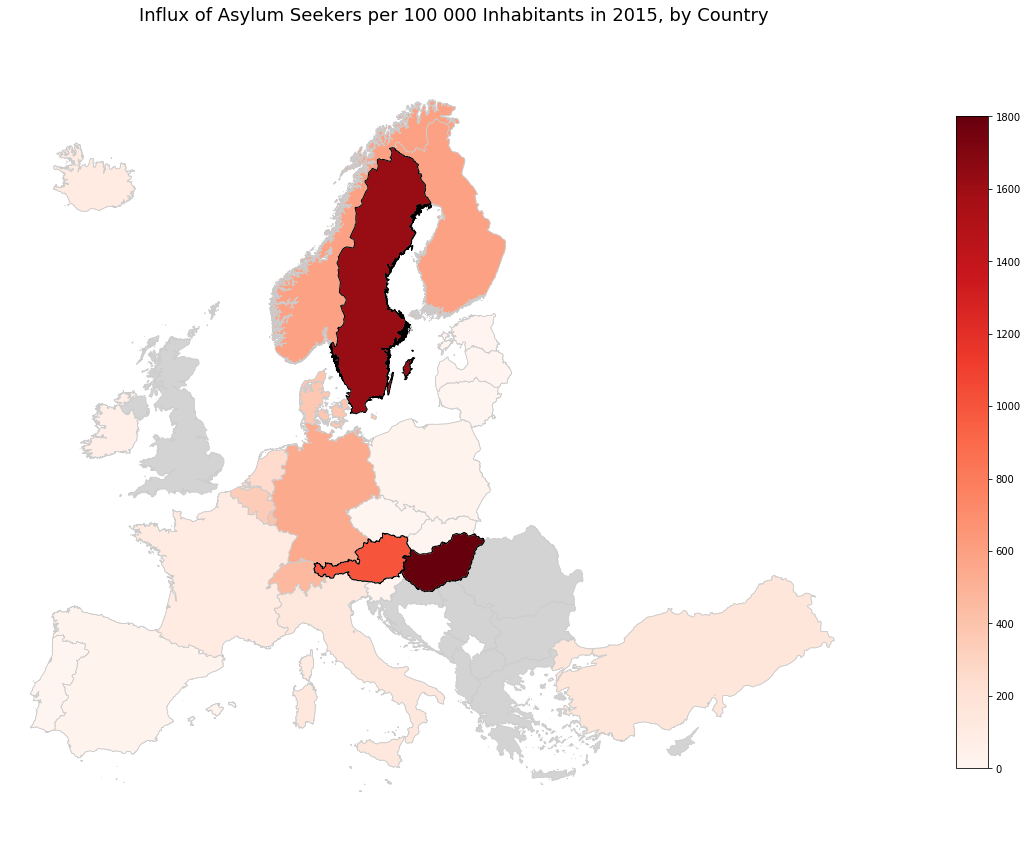

In [9]:
#setting fig, ax objects
fig,ax = plt.subplots(figsize=(20,20))

#layer 1 (all patches grey)
map_ref.plot(column = 'Refugees 2015' , ax = ax, color='#D3D3D3', linewidth=0.8, edgecolor='0.8')
#layer 2 (filled in data; NA grey)
map_ref2.plot(column= 'asylum_seekers_per_100000' , ax = ax, cmap='Reds', linewidth=0.8, edgecolor='0.8')
ax.set_xlim(2500000,7700000)
ax.set_ylim(1000000,)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off') #remove the axes
ax.set_title('Influx of Asylum Seekers per 100 000 Inhabitants in 2015, by Country', fontsize = 18)

#color scheme for chloropleth
vmin, vmax = 0, 1800 
#create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds',norm=plt.Normalize(vmin=0, vmax=1800),)
# empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm, shrink = 0.6, ax = ax, pad=0.05)


#highlighting relevant countries
SE15 = plotCountryPatch(ax,'SE', 'black') #Sweden
HU15 = plotCountryPatch(ax,'HU', 'black') #Hungary
AT15 = plotCountryPatch(ax,'AT', 'black') #Austria
#plt.tight_layout()

#### Interactive Map (Bokeh)

In [18]:
from bokeh.io import output_notebook, output_file, show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.resources import INLINE

In [19]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = map_ref.to_json())

In [20]:
# Define color palettes
palette = brewer['OrRd'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1600, nan_color = '#d9d9d9')

# Define custom tick labels for color bar.
tick_labels = {'0': '0', '200': '200',
 '400':'400', '600':'600',
 '800':'800', '1000':'1000',
 '1200':'1200', '1400':'1400',
 '1600':'1600', '1800':'1800'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)


# Create figure object.
p = figure(title = 'Asylum Seekers per 100 000 citizens in 2015, by Country', 
           plot_height = 950 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
           x_range=(2100000,8300000),y_range=(0,6200000))
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# Add patch renderer to figure.
countries = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'asylum_seekers_per_100000',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p.add_tools(HoverTool(renderers = [countries],
                      tooltips = [('Country','@NUTS_NAME'),
                                ('Refugees per 100 000 Citizens','@asylum_seekers_per_100000')]))

# Specify layout
p.add_layout(color_bar, 'below')

# hide x-y-axes
p.axis.visible = False

output_notebook(resources=INLINE)
output_file('refugees_2015_chloropleths','Asylum Seekers per 100 000 citizens in 2015, by Country')
show(p)

Loading BokehJS ...

### Geographical Analysis of the Perceptions on Immigrants (in 2014 and 2016)

C:\Users\User\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\User\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


Text(0.45, 0.23, 'Responses to Question: "Immigrants make country better (10) or worse (0) place to live?", by Country')

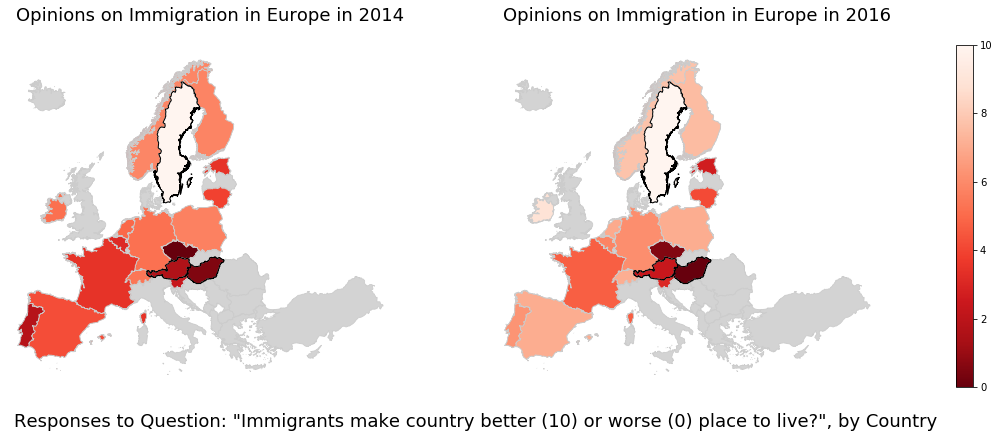

In [13]:
#setting fig, ax objects
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(20, (1.05 * 20 / 2)),subplot_kw={'aspect': 1})

map14_filled.plot(column='imwbcnt', ax = ax[0], color='#D3D3D3', linewidth=0.8, edgecolor='0.8')#layer 1
map14_filled.dropna().plot(column='imwbcnt', ax = ax[0], cmap='Reds_r', linewidth=0.8, edgecolor='0.8')#layer 2
ax[0].set_xlim(2500000,7700000)
ax[0].set_ylim(1000000,)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].axis('off') #remove the axes
ax[0].set_title('Opinions on Immigration in Europe in 2014', fontsize = 18)

map16_filled.plot(column='imwbcnt', ax = ax[1], color='#D3D3D3', linewidth=0.8, edgecolor='0.8')
map16_filled.dropna().plot(column='imwbcnt', ax = ax[1], cmap='Reds_r', linewidth=0.8, edgecolor='0.8')
ax[1].set_xlim(2500000,7700000)
ax[1].set_ylim(1000000,)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].axis('off')#remove the axes
ax[1].set_title('Opinions on Immigration in Europe in 2016', fontsize = 18)

#color scheme for chloropleth
vmin, vmax = 20, 220 
#create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds_r',norm=plt.Normalize(vmin=0, vmax=10),)#
# empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm, shrink = 0.6, ax = [ax[0],ax[1]],pad=0.05)


#highlighting countries with high per-capita immigration in 2015
SE14 = plotCountryPatch(ax[0],'SE', 'black') #Sweden
SE16 = plotCountryPatch(ax[1],'SE', 'black')
HU14 = plotCountryPatch(ax[0],'HU', 'black') #Hungary
HU16 = plotCountryPatch(ax[1],'HU', 'black')
AT14 = plotCountryPatch(ax[0],'AT', 'black') #Austria
AT16 = plotCountryPatch(ax[1],'AT', 'black')

#plt.tight_layout()
fig.text(0.45, 0.23,\
         'Responses to Question: "Immigrants make country better (10) or worse (0) place to live?", by Country'\
         ,horizontalalignment='center',verticalalignment='center', fontsize  = 18)